In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rachayitabora","key":"50e4ae837c08c65710825963198ca299"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip -d /content/



Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:19<00:00, 196MB/s]
100% 2.13G/2.13G [00:19<00:00, 119MB/s]


In [ ]:
import os

data_dir = '/content/leapgestrecog/leapGestRecog'
categories = os.listdir(data_dir)
print("Gesture categories:", categories)

# Check contents of a sample category
sample_category = categories[0]
sample_category_path = os.path.join(data_dir, sample_category)
print(f"Contents of {sample_category}:", os.listdir(sample_category_path)[:5])


Gesture categories: ['02', '08', '06', '03', '00', '05', '09', '01', '04', '07']
Contents of 02: ['10_down', '01_palm', '05_thumb', '04_fist_moved', '08_palm_moved']


In [ ]:
import os
import cv2
import numpy as np

data_dir = '/content/leapgestrecog/leapGestRecog'
images = []
labels = []
label_names = []

for label, category in enumerate(sorted(os.listdir(data_dir))):
    category_path = os.path.join(data_dir, category)
    for gesture_folder in os.listdir(category_path):
        gesture_path = os.path.join(category_path, gesture_folder)
        # Store label name for reference
        label_names.append(gesture_folder)
        for file in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(f"Total images: {images.shape[0]}")
print(f"Image shape: {images[0].shape}")
print(f"Number of labels: {len(set(labels))}")


Total images: 20000
Image shape: (64, 64, 3)
Number of labels: 10


In [ ]:
#  Split dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
#  Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
#  Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()  # only normalization

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [ ]:
#  Build CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(set(labels))  # total gesture classes

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,722 (4.87 MB)

 Trainable params: 1,275,722 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Train the model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

checkpoint = ModelCheckpoint('gesture_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=25,  # increase for better accuracy
        callbacks=[checkpoint],
        verbose=1
    )

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2261 - loss: 2.1040
Epoch 1: val_accuracy improved from -inf to 0.83425, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.2266 - loss: 2.1028 - val_accuracy: 0.8342 - val_loss: 0.6180
Epoch 2/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6520 - loss: 0.9614
Epoch 2: val_accuracy improved from 0.83425 to 0.94300, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.6522 - loss: 0.9609 - val_accuracy: 0.9430 - val_loss: 0.1910
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7948 - loss: 0.5612
Epoch 3: val_accuracy did not improve from 0.94300
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7949 - loss: 0.5610 - val_accuracy: 0.9237 - val_loss: 0.1972
Epoch 4/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8702 - loss: 0.3569
Epoch 4: val_accuracy improved from 0.94300 to 0.96800, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8702 - loss: 0.3568 - val_accuracy: 0.9680 - val_loss: 0.0970
Epoch 5/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8977 - loss: 0.2770
Epoch 5: val_accuracy improved from 0.96800 to 0.97750, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.8977 - loss: 0.2770 - val_accuracy: 0.9775 - val_loss: 0.0577
Epoch 6/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9165 - loss: 0.2267
Epoch 6: val_accuracy improved from 0.97750 to 0.98100, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9166 - loss: 0.2266 - val_accuracy: 0.9810 - val_loss: 0.0445
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9275 - loss: 0.1961
Epoch 7: val_accuracy improved from 0.98100 to 0.98200, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9276 - loss: 0.1960 - val_accuracy: 0.9820 - val_loss: 0.0369
Epoch 8/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9363 - loss: 0.1661
Epoch 8: val_accuracy did not improve from 0.98200
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.9364 - loss: 0.1661 - val_accuracy: 0.9590 - val_loss: 0.1030
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9481 - loss: 0.1451
Epoch 9: val_accuracy did not improve from 0.98200
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9481 - loss: 0.1451 - val_accuracy: 0.9797 - val_loss: 0.0420
Epoch 10/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9515 - loss: 0.1271
Epoch 10: val_accuracy improved from 0.98200 to 0.99150, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.9515 - loss: 0.1271 - val_accuracy: 0.9915 - val_loss: 0.0179
Epoch 11/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9493 - loss: 0.1357
Epoch 11: val_accuracy improved from 0.99150 to 0.99300, saving model to gesture_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9493 - loss: 0.1357 - val_accuracy: 0.9930 - val_loss: 0.0152
Epoch 12/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9585 - loss: 0.1106
Epoch 12: val_accuracy did not improve from 0.99300
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9585 - loss: 0.1106 - val_accuracy: 0.9883 - val_loss: 0.0292
Epoch 13/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9577 - loss: 0.1145
Epoch 13: val_accuracy did not improve from 0.99300
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9577 - loss: 0.1145 - val_accuracy: 0.9923 - val_loss: 0.0209
Epoch 14/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9612 - loss: 0.1046
Epoch 14: val_accuracy did not improve from 0.99300
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9612 - loss: 0.1045 - val_accuracy: 0.9890 - val_loss: 0.0217
Epoch 15/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9610 - loss: 0.1084
Epoch 15: val_ac

In [ ]:
# Load the best model
model = load_model('gesture_model.h5')

In [ ]:
#  Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0180
Test Accuracy: 99.30%


In [ ]:
from google.colab import output
from google.colab import widgets
from IPython.display import display, HTML
import cv2
import numpy as np
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = HTML('''
        <input type="file" accept="image/*" capture="camera" id="cam_input">
        <script>
        const input = document.getElementById('cam_input');
        input.onchange = e => {
            const file = input.files[0];
            const reader = new FileReader();
            reader.onload = () => {
                const base64 = reader.result;
                google.colab.kernel.invokeFunction('notebook.receive_photo', [base64], {});
            };
            reader.readAsDataURL(file);
        }
        </script>
    ''')
    display(js)

photo_data = None

def receive_photo(base64_str):
    global photo_data
    photo_data = base64_str.split(',')[1]

output.register_callback('notebook.receive_photo', receive_photo)

# Run this to open webcam and capture
take_photo()


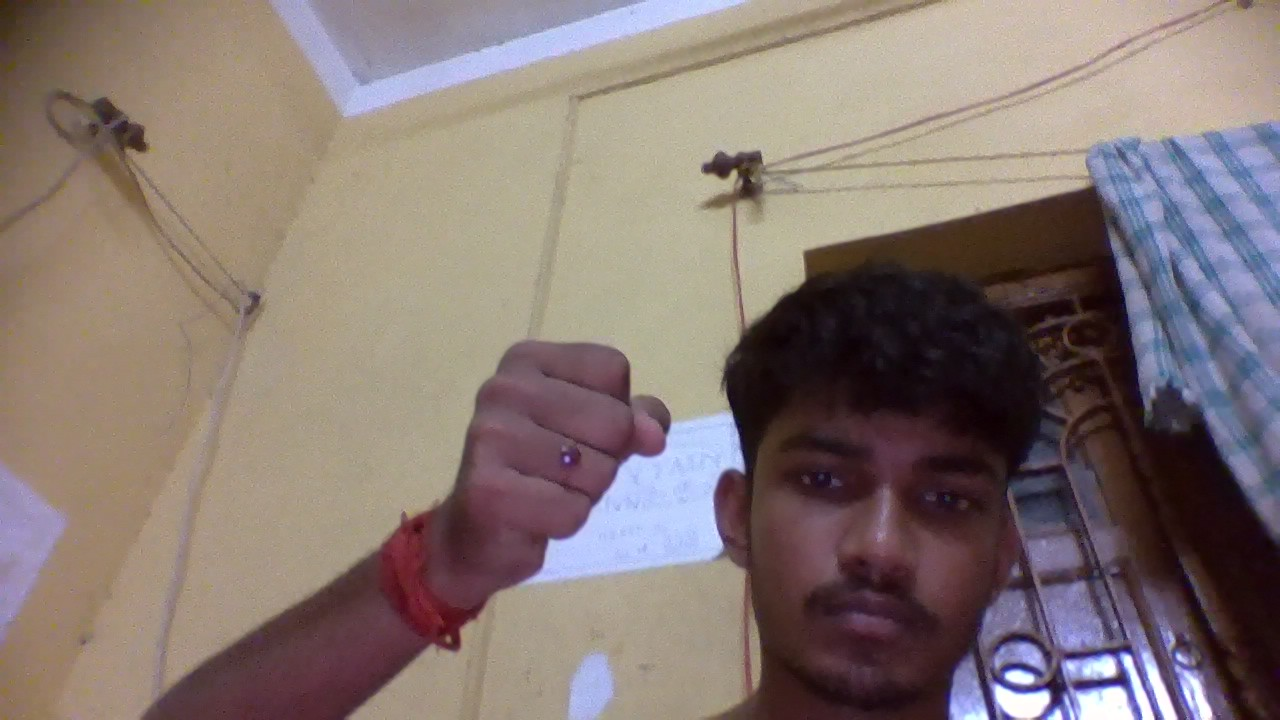

In [ ]:
nparr = np.frombuffer(b64decode(photo_data), np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Show in Colab
from google.colab.patches import cv2_imshow
cv2_imshow(img)


In [ ]:
roi = cv2.resize(img, (64,64))
roi = roi / 255.0
roi = np.expand_dims(roi, axis=0)

prediction = model.predict(roi)
gesture_id = np.argmax(prediction)
gesture_name = label_mapping.get(gesture_id, "Unknown")
print("Predicted Gesture:", gesture_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Gesture: 01_palm


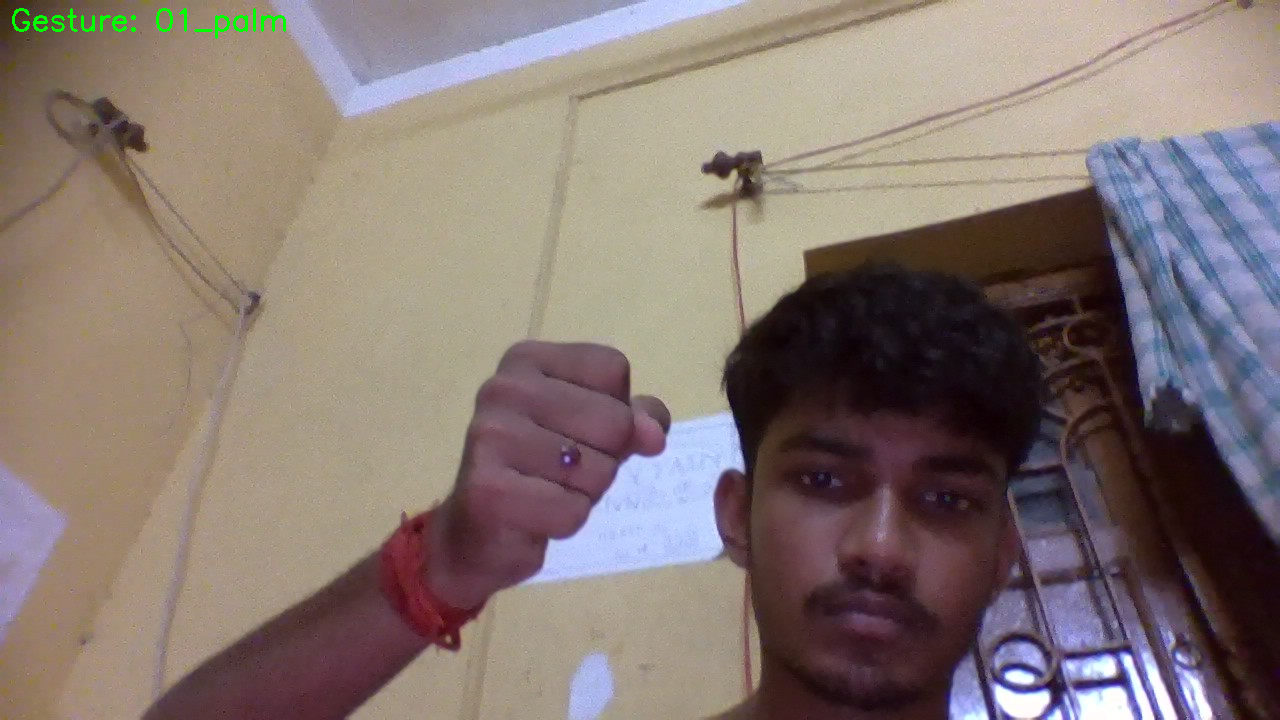

In [ ]:
# Overlay predicted gesture on the image
cv2.putText(img, f"Gesture: {gesture_name}", (10,30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

# Display in Colab
from google.colab.patches import cv2_imshow
cv2_imshow(img)


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

model = load_model("gesture_model.h5")
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    roi = cv2.resize(frame, (64,64)) / 255.0
    roi = np.expand_dims(roi, axis=0)
    pred = model.predict(roi)
    gesture = label_mapping[np.argmax(pred)]
    cv2.putText(frame, gesture, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("Gesture", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
